## Data Validation: Verify Mouse PPI File

Before running the analysis, let's verify the PPI data is correct for mouse.

In [1]:
import pandas as pd
import gc

print("VALIDATING MOUSE PPI DATA\n" + "="*60)

# Load only first 1000 rows for validation (memory efficient)
print("\nLoading sample for validation (1000 rows)...")
ppi_sample = pd.read_csv('./mouse_ppi.txt', sep=' ', nrows=1000)

print(f"\n1. FILE STRUCTURE (sample):\n   - Columns: {list(ppi_sample.columns)}\n   First 3 rows:\n{ppi_sample.head(3).to_string(index=False)}")

sample_proteins = ppi_sample['protein1'].head(10).tolist()
is_mouse = all(str(p).startswith('10090.') for p in sample_proteins)
print(f"\n2. ORGANISM VERIFICATION:\n   - Mouse IDs (10090.): {is_mouse} {'OK' if is_mouse else 'FAIL'}")

print(f"\n3. ID FORMAT:\n   - Example: {ppi_sample['protein1'].iloc[0]} (Ensembl protein IDs)")

scores = ppi_sample['combined_score']
print(f"\n4. SCORE DISTRIBUTION:\n   - Min: {scores.min()}, Max: {scores.max()}, Mean: {scores.mean():.2f}\n   - High confidence (>700): {(scores > 700).sum():,} interactions")

print("\n5. DATA SOURCE:\n   - STRING database (https://string-db.org)\n   - Format: STRING protein.links")

print("\n6. Note: Full data will be loaded during analysis with memory optimizations")

print("\nVALIDATION COMPLETE: REAL mouse PPI data from STRING\n")

# Clean up
del ppi_sample, sample_proteins, scores
gc.collect()

VALIDATING MOUSE PPI DATA

Loading sample for validation (1000 rows)...

1. FILE STRUCTURE (sample):
   - Columns: ['protein1', 'protein2', 'combined_score']
   First 3 rows:
                protein1                 protein2  combined_score
10090.ENSMUSP00000000001 10090.ENSMUSP00000027991             889
10090.ENSMUSP00000000001 10090.ENSMUSP00000137332             163
10090.ENSMUSP00000000001 10090.ENSMUSP00000041756             201

2. ORGANISM VERIFICATION:
   - Mouse IDs (10090.): True OK

3. ID FORMAT:
   - Example: 10090.ENSMUSP00000000001 (Ensembl protein IDs)

4. SCORE DISTRIBUTION:
   - Min: 150, Max: 989, Mean: 340.87
   - High confidence (>700): 153 interactions

5. DATA SOURCE:
   - STRING database (https://string-db.org)
   - Format: STRING protein.links

6. Note: Full data will be loaded during analysis with memory optimizations

VALIDATION COMPLETE: REAL mouse PPI data from STRING



0

## Phase 3: Network Analysis - Why This Approach?

**Goal:** Identify hub genes (key regulators) from 1,876 DEGs using protein-protein interaction (PPI) network topology.

**Why networks matter:**
- **Biological systems are networks** - genes don't act independently, they interact
- **Hub genes = high leverage points** - perturbing well-connected nodes has cascading effects
- **Network context reveals function** - genes with similar network positions have similar roles

**Computational pipeline:**
1. **Load DEGs** → nodes (1,876 genes from Phase 1)
2. **Load PPI data** → edges (STRING database: 12.6M mouse interactions, filtered to score>400)
3. **Map IDs** → Ensembl protein IDs → Entrez gene IDs (required for integration)
4. **Filter to DEG-DEG** → only keep interactions between differentially expressed genes
5. **Extract LCC** → largest connected component (main network cluster)
6. **Compute degree centrality** → count connections per node
7. **Rank by degree** → top nodes = hub genes = key regulators

**Why degree centrality?**
- Simple, interpretable metric (# of connections)
- Hub genes (high degree) are statistically enriched for:
  - Essential genes
  - Disease genes  
  - Drug targets
- Validated by 1000s of network biology studies

**Why filter to DEG-DEG interactions?**
- Focus on differential expression context
- Reduces network size from 1.6M to ~14K edges (computational efficiency)
- Only includes genes showing strain-specific changes

**Memory optimizations applied:**
- Filter PPI by confidence score > 400 (87% memory reduction)
- Load only essential columns
- Garbage collection after major operations
- Process data in stages

**Actual output:**
- Network: 1,302 nodes, 7,138 edges (LCC)
- Top 10 hub genes ranked by connectivity (degree range: 64-147)
- Saved as CSV for downstream analysis

In [2]:
# Phase 3: Network Analysis with Python/NetworkX using REAL Mouse PPI Data
import pandas as pd
import networkx as nx
import numpy as np
import os
import gc

print('Phase 3: Network Medicine Analysis (Python)')
print('=' * 50)

# Load DEGs from Phase 1
print('\n1. Loading DEGs from Phase 1...')
degs_df = pd.read_csv('degs_for_network.csv')
degs_df['entrez_id'] = degs_df['entrez_id'].astype(str)
print(f'   Loaded {len(degs_df)} DEGs with Entrez IDs')

# Load REAL Mouse PPI data from STRING - with filtering to reduce memory
print('\n2. Loading mouse PPI data (memory-optimized)...')
ppi_df = pd.read_csv('./mouse_ppi.txt', sep=' ')
original_size = len(ppi_df)
# Filter to medium-high confidence interactions (score > 400)
ppi_df = ppi_df[ppi_df['combined_score'] > 400].copy()
print(f'   Loaded {len(ppi_df):,} interactions (filtered from {original_size:,}, score>400)')
print(f'   Memory saved: {(1 - len(ppi_df)/original_size)*100:.1f}%')

# Parse Ensembl protein IDs (remove species prefix "10090.")
print('\n3. Parsing Ensembl protein IDs...')
ppi_df['protein1_clean'] = ppi_df['protein1'].str.replace('10090.', '', regex=False)
ppi_df['protein2_clean'] = ppi_df['protein2'].str.replace('10090.', '', regex=False)

# Load Ensembl to Entrez mapping from NCBI
print('\n4. Loading Ensembl-to-Entrez ID mapping...')
try:
    import requests
    from io import BytesIO
    
    cache_file = './gene2ensembl_mouse.tsv'
    
    if os.path.exists(cache_file):
        print(f'   Using cached mapping from {cache_file}')
        mouse_map = pd.read_csv(cache_file, sep='\t')
    else:
        print('   Downloading gene2ensembl.gz from NCBI (this may take 2-3 minutes)...')
        url = "https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2ensembl.gz"
        
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        if total_size > 0:
            print(f'   File size: {total_size / (1024*1024):.1f} MB')
        
        chunk_size = 1024 * 1024
        downloaded = 0
        chunks = []
        
        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:
                chunks.append(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    percent = (downloaded / total_size) * 100
                    print(f'   Downloaded: {percent:.1f}% ({downloaded/(1024*1024):.1f} MB)', end='\r')
        
        print('\n   Parsing downloaded file...')
        
        full_data = b''.join(chunks)
        gene_map = pd.read_csv(BytesIO(full_data), sep='\t', compression='gzip')
        mouse_map = gene_map[gene_map['#tax_id'] == 10090][['GeneID', 'Ensembl_protein_identifier']].dropna()
        
        del gene_map, full_data, chunks
        gc.collect()
        
        mouse_map.to_csv(cache_file, sep='\t', index=False)
        print(f'   Cached mapping saved to {cache_file}')
    
    mouse_map['GeneID'] = mouse_map['GeneID'].astype(str)
    mouse_map['Ensembl_clean'] = mouse_map['Ensembl_protein_identifier'].str.split('.').str[0]
    
    ensembl_to_entrez = dict(zip(mouse_map['Ensembl_clean'], mouse_map['GeneID']))
    print(f'   Mapped {len(ensembl_to_entrez):,} Ensembl proteins to Entrez IDs')
    
    del mouse_map
    gc.collect()
    
except Exception as e:
    print(f'   WARNING: Could not download NCBI mapping ({str(e)})')
    ensembl_to_entrez = {}

# Map PPI to Entrez IDs
print('\n5. Mapping PPI network to Entrez IDs...')
ppi_df['entrez1'] = ppi_df['protein1_clean'].map(ensembl_to_entrez)
ppi_df['entrez2'] = ppi_df['protein2_clean'].map(ensembl_to_entrez)
ppi_mapped = ppi_df[['entrez1', 'entrez2', 'combined_score']].dropna(subset=['entrez1', 'entrez2']).copy()
print(f'   Successfully mapped {len(ppi_mapped):,} interactions to Entrez IDs')

del ppi_df, ensembl_to_entrez
gc.collect()

# Filter to only include DEG-DEG interactions
print('\n6. Filtering PPI to DEG-DEG interactions only...')
deg_entrez = set(degs_df['entrez_id'])
ppi_degs = ppi_mapped[
    ppi_mapped['entrez1'].isin(deg_entrez) & 
    ppi_mapped['entrez2'].isin(deg_entrez)
].copy()
print(f'   Found {len(ppi_degs):,} interactions among DEGs')

# Build network from REAL PPI data
print('\n7. Building network from REAL protein interactions...')
G = nx.Graph()

# Add all DEG nodes
for _, row in degs_df.iterrows():
    G.add_node(str(row['entrez_id']), 
              gene_id=row['gene_id'], 
              logFC=row['logFC'], 
              FDR=row['FDR'])

# Add edges
edges_added = 0
if len(ppi_degs) > 0:
    for _, row in ppi_degs.iterrows():
        G.add_edge(row['entrez1'], row['entrez2'], score=row['combined_score'])
        edges_added += 1
    print(f'   Added {edges_added:,} REAL protein-protein interaction edges')
else:
    print('   WARNING: No PPI edges found for DEGs')

# Get largest connected component
if G.number_of_edges() > 0:
    components = list(nx.connected_components(G))
    if components:
        lcc = max(components, key=len)
        G_lcc = G.subgraph(lcc).copy()
        print(f'   Largest connected component: {len(G_lcc.nodes())} nodes, {len(G_lcc.edges())} edges')
        G = G_lcc

print(f'\nCreated network: {len(G.nodes())} nodes, {len(G.edges())} edges')

# Network statistics
degrees = dict(G.degree())
print(f'\n8. Network Statistics:')
print(f'   - Total nodes: {len(G.nodes())}')
print(f'   - Total edges: {len(G.edges())}')
if degrees:
    print(f'   - Average degree: {np.mean(list(degrees.values())):.2f}')
    print(f'   - Max degree: {max(degrees.values())}')
print(f'   - Connected components: {nx.number_connected_components(G)}')
if G.number_of_edges() > 0 and nx.is_connected(G):
    print(f'   - Network density: {nx.density(G):.4f}')
print(f'   - Data source: REAL mouse PPI from STRING')

# Identify key regulators
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
print(f'\n9. Top 10 Key Regulators by Network Connectivity:')
print('-' * 80)
print(f'{"Rank":<4} {"Gene ID":<20} {"Degree":<8} {"logFC":<10} {"Direction":<12} {"FDR":<15}')
print('-' * 80)

key_regulators = []
for i, (node, degree) in enumerate(sorted_degrees[:10]):
    if node in G.nodes():
        node_data = G.nodes[node]
        direction = 'UP' if node_data['logFC'] > 0 else 'DOWN'
        significance = '***' if node_data['FDR'] < 1e-100 else '**' if node_data['FDR'] < 1e-50 else '*'
        
        print(f'{i+1:<4} {node_data["gene_id"]:<20} {degree:<8} {node_data["logFC"]:<10.2f} {direction:<12} {node_data["FDR"]:<15.2e}{significance}')
        
        key_regulators.append({
            'rank': i+1,
            'entrez_id': node,
            'gene_id': node_data['gene_id'],
            'degree': degree,
            'logFC': node_data['logFC'],
            'FDR': node_data['FDR'],
            'direction': direction
        })

# Save results
kr_df = pd.DataFrame(key_regulators)
kr_df.to_csv('key_regulators_phase3.csv', index=False)
print('\nKey regulators saved to key_regulators_phase3.csv')

# Clean up
del ppi_degs
gc.collect()

# Summary
upregulated = sum(1 for _, data in G.nodes(data=True) if data['logFC'] > 0)
downregulated = sum(1 for _, data in G.nodes(data=True) if data['logFC'] < 0)

print('\n10. Summary of Network Analysis:')
print(f'    - Total DEGs: {len(degs_df)}')
print(f'    - Network nodes: {len(G.nodes())}')
print(f'    - Network edges: {len(G.edges())} (REAL protein interactions)')
print(f'    - Upregulated in NOD: {upregulated}')
print(f'    - Downregulated in NOD: {downregulated}')
print(f'    - Average |logFC|: {abs(degs_df["logFC"]).mean():.3f}')
print(f'    - Data source: STRING mouse PPI database')

Phase 3: Network Medicine Analysis (Python)

1. Loading DEGs from Phase 1...
   Loaded 1876 DEGs with Entrez IDs

2. Loading mouse PPI data (memory-optimized)...
   Loaded 1,617,976 interactions (filtered from 12,684,354, score>400)
   Memory saved: 87.2%

3. Parsing Ensembl protein IDs...

4. Loading Ensembl-to-Entrez ID mapping...
   Using cached mapping from ./gene2ensembl_mouse.tsv
   Mapped 34,981 Ensembl proteins to Entrez IDs

5. Mapping PPI network to Entrez IDs...
   Successfully mapped 1,434,402 interactions to Entrez IDs

6. Filtering PPI to DEG-DEG interactions only...
   Found 14,308 interactions among DEGs

7. Building network from REAL protein interactions...
   Added 14,308 REAL protein-protein interaction edges
   Largest connected component: 1302 nodes, 7138 edges

Created network: 1302 nodes, 7138 edges

8. Network Statistics:
   - Total nodes: 1302
   - Total edges: 7138
   - Average degree: 10.96
   - Max degree: 147
   - Connected components: 1
   - Network densit

## Random Walk Network Propagation

Now let's use **random walk** to find genes that aren't DEGs themselves but are highly connected to DEGs in the PPI network. This can reveal hidden regulators and bridge proteins.

In [3]:
# Random Walk Propagation - Find network-proximal genes to DEGs
import networkx as nx
import numpy as np
import random
import gc

print('\nPhase 3b: Random Walk Network Propagation')
print('=' * 50)

# Build FULL PPI network (not just DEG-DEG)
print('\n1. Building full PPI network (all genes)...')
G_full = nx.Graph()
for _, row in ppi_mapped.iterrows():
    G_full.add_edge(str(row['entrez1']), str(row['entrez2']), score=row['combined_score'])

print(f'   - Full network: {G_full.number_of_nodes():,} nodes, {G_full.number_of_edges():,} edges')

# Get largest connected component
lcc_full = max(nx.connected_components(G_full), key=len)
G_full = G_full.subgraph(lcc_full).copy()
print(f'   - LCC: {G_full.number_of_nodes():,} nodes, {G_full.number_of_edges():,} edges')

# Define seed genes (our DEGs that exist in the full network)
seed_genes = [str(entrez) for entrez in degs_df['entrez_id'] if str(entrez) in G_full.nodes()]
print(f'\n2. Seed genes (DEGs in network): {len(seed_genes)}')

# Random walk function with restart probability
def random_walk_with_restart(G, seeds, restart_prob=0.3, num_iterations=1000, seed_value=42):
    """
    Perform random walk WITH RESTART from seed genes
    restart_prob: probability of returning to a seed node (allows exploration)
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    
    # Initialize visit counts
    visit_counts = {node: 0 for node in G.nodes()}
    
    # Perform multiple random walks
    total_walks = len(seeds) * num_iterations
    
    for i in range(total_walks):
        # Start from random seed
        current = random.choice(seeds)
        
        # Walk for random length (10-50 steps)
        walk_length = random.randint(10, 50)
        
        for step in range(walk_length):
            # Count visit
            visit_counts[current] += 1
            
            # Restart probability - jump back to random seed
            if random.random() < restart_prob:
                current = random.choice(seeds)
            else:
                # Continue walking to random neighbor
                neighbors = list(G.neighbors(current))
                if neighbors:
                    current = random.choice(neighbors)
                else:
                    # Dead end - restart
                    current = random.choice(seeds)
    
    # Normalize scores (don't force seeds to 1.0 - let natural scoring emerge)
    max_visits = max(visit_counts.values()) if visit_counts else 1
    scores = {node: count / max_visits for node, count in visit_counts.items()}
    
    return scores

# Run random walk with restart
print('\n3. Running random walk with restart (30% restart prob, 1000 iterations)...')
print('   This may take a minute...')
rw_scores = random_walk_with_restart(G_full, seed_genes, restart_prob=0.3, num_iterations=1000, seed_value=42)

# Get top scored genes
top_200_rw = sorted(rw_scores.items(), key=lambda x: x[1], reverse=True)[:200]
print(f'   Complete! Scored {len(rw_scores):,} genes')

# Analyze results
print('\n4. Random Walk Results:')
top_200_entrez = [gene_id for gene_id, _ in top_200_rw]
enriched_genes_rw = [g for g in top_200_entrez if g not in seed_genes]
print(f'   - Top 200 genes: {len(top_200_rw)}')
print(f'   - Original DEG seeds: {len([g for g in top_200_entrez if g in seed_genes])}')
print(f'   - NEW enriched genes (non-DEGs): {len(enriched_genes_rw)}')

print('\n5. Top 10 genes by Random Walk score:')
print('-' * 80)
print(f'{"Rank":<4} {"Entrez ID":<12} {"Score":<8} {"Type":<10} {"Degree":<8}')
print('-' * 80)

rw_top_genes = []
for i, (gene_id, score) in enumerate(top_200_rw[:10]):
    gene_type = 'DEG Seed' if gene_id in seed_genes else 'ENRICHED'
    degree = G_full.degree(gene_id)
    print(f'{i+1:<4} {gene_id:<12} {score:<8.4f} {gene_type:<10} {degree:<8}')
    
    rw_top_genes.append({
        'rank': i+1,
        'entrez_id': gene_id,
        'rw_score': score,
        'type': gene_type,
        'degree': degree
    })

# Save random walk top genes
rw_df = pd.DataFrame([{'entrez_id': gid, 'rw_score': score, 'type': 'DEG Seed' if gid in seed_genes else 'ENRICHED'} 
                      for gid, score in top_200_rw])
rw_df.to_csv('random_walk_top_genes.csv', index=False)
print('\n   Random walk top 200 genes saved to random_walk_top_genes.csv')

# Free memory after random walk
print('   Cleaning up memory...')
del rw_scores
gc.collect()

# Compare with degree centrality results
print('\n6. Comparison with Degree Centrality:')
deg_cent_top = [node for node, _ in sorted_degrees[:10]]
rw_top = [gene_id for gene_id, _ in top_200_rw[:10]]
overlap = set(deg_cent_top) & set(rw_top)
print(f'   - Degree centrality top 10: {deg_cent_top[:5]}...')
print(f'   - Random walk top 10: {rw_top[:5]}...')
print(f'   - Overlap: {len(overlap)} genes')
print(f'   - NEW discoveries by random walk: {10 - len(overlap)} genes')

print('\nRandom Walk Propagation Complete!')


Phase 3b: Random Walk Network Propagation

1. Building full PPI network (all genes)...
   - Full network: 18,718 nodes, 717,036 edges
   - LCC: 18,661 nodes, 717,000 edges

2. Seed genes (DEGs in network): 1663

3. Running random walk with restart (30% restart prob, 1000 iterations)...
   This may take a minute...
   Complete! Scored 18,661 genes

4. Random Walk Results:
   - Top 200 genes: 200
   - Original DEG seeds: 186
   - NEW enriched genes (non-DEGs): 14

5. Top 10 genes by Random Walk score:
--------------------------------------------------------------------------------
Rank Entrez ID    Score    Type       Degree  
--------------------------------------------------------------------------------
1    21849        1.0000   ENRICHED   369     
2    110454       0.7347   DEG Seed   81      
3    66039        0.5626   DEG Seed   81      
4    59069        0.5198   DEG Seed   144     
5    14109        0.5164   DEG Seed   665     
6    14433        0.4949   DEG Seed   1578    
7  


Generating improved network visualization...
   Visualizing top 50 hub genes: 50 nodes, 448 edges
   Computing optimal layout...


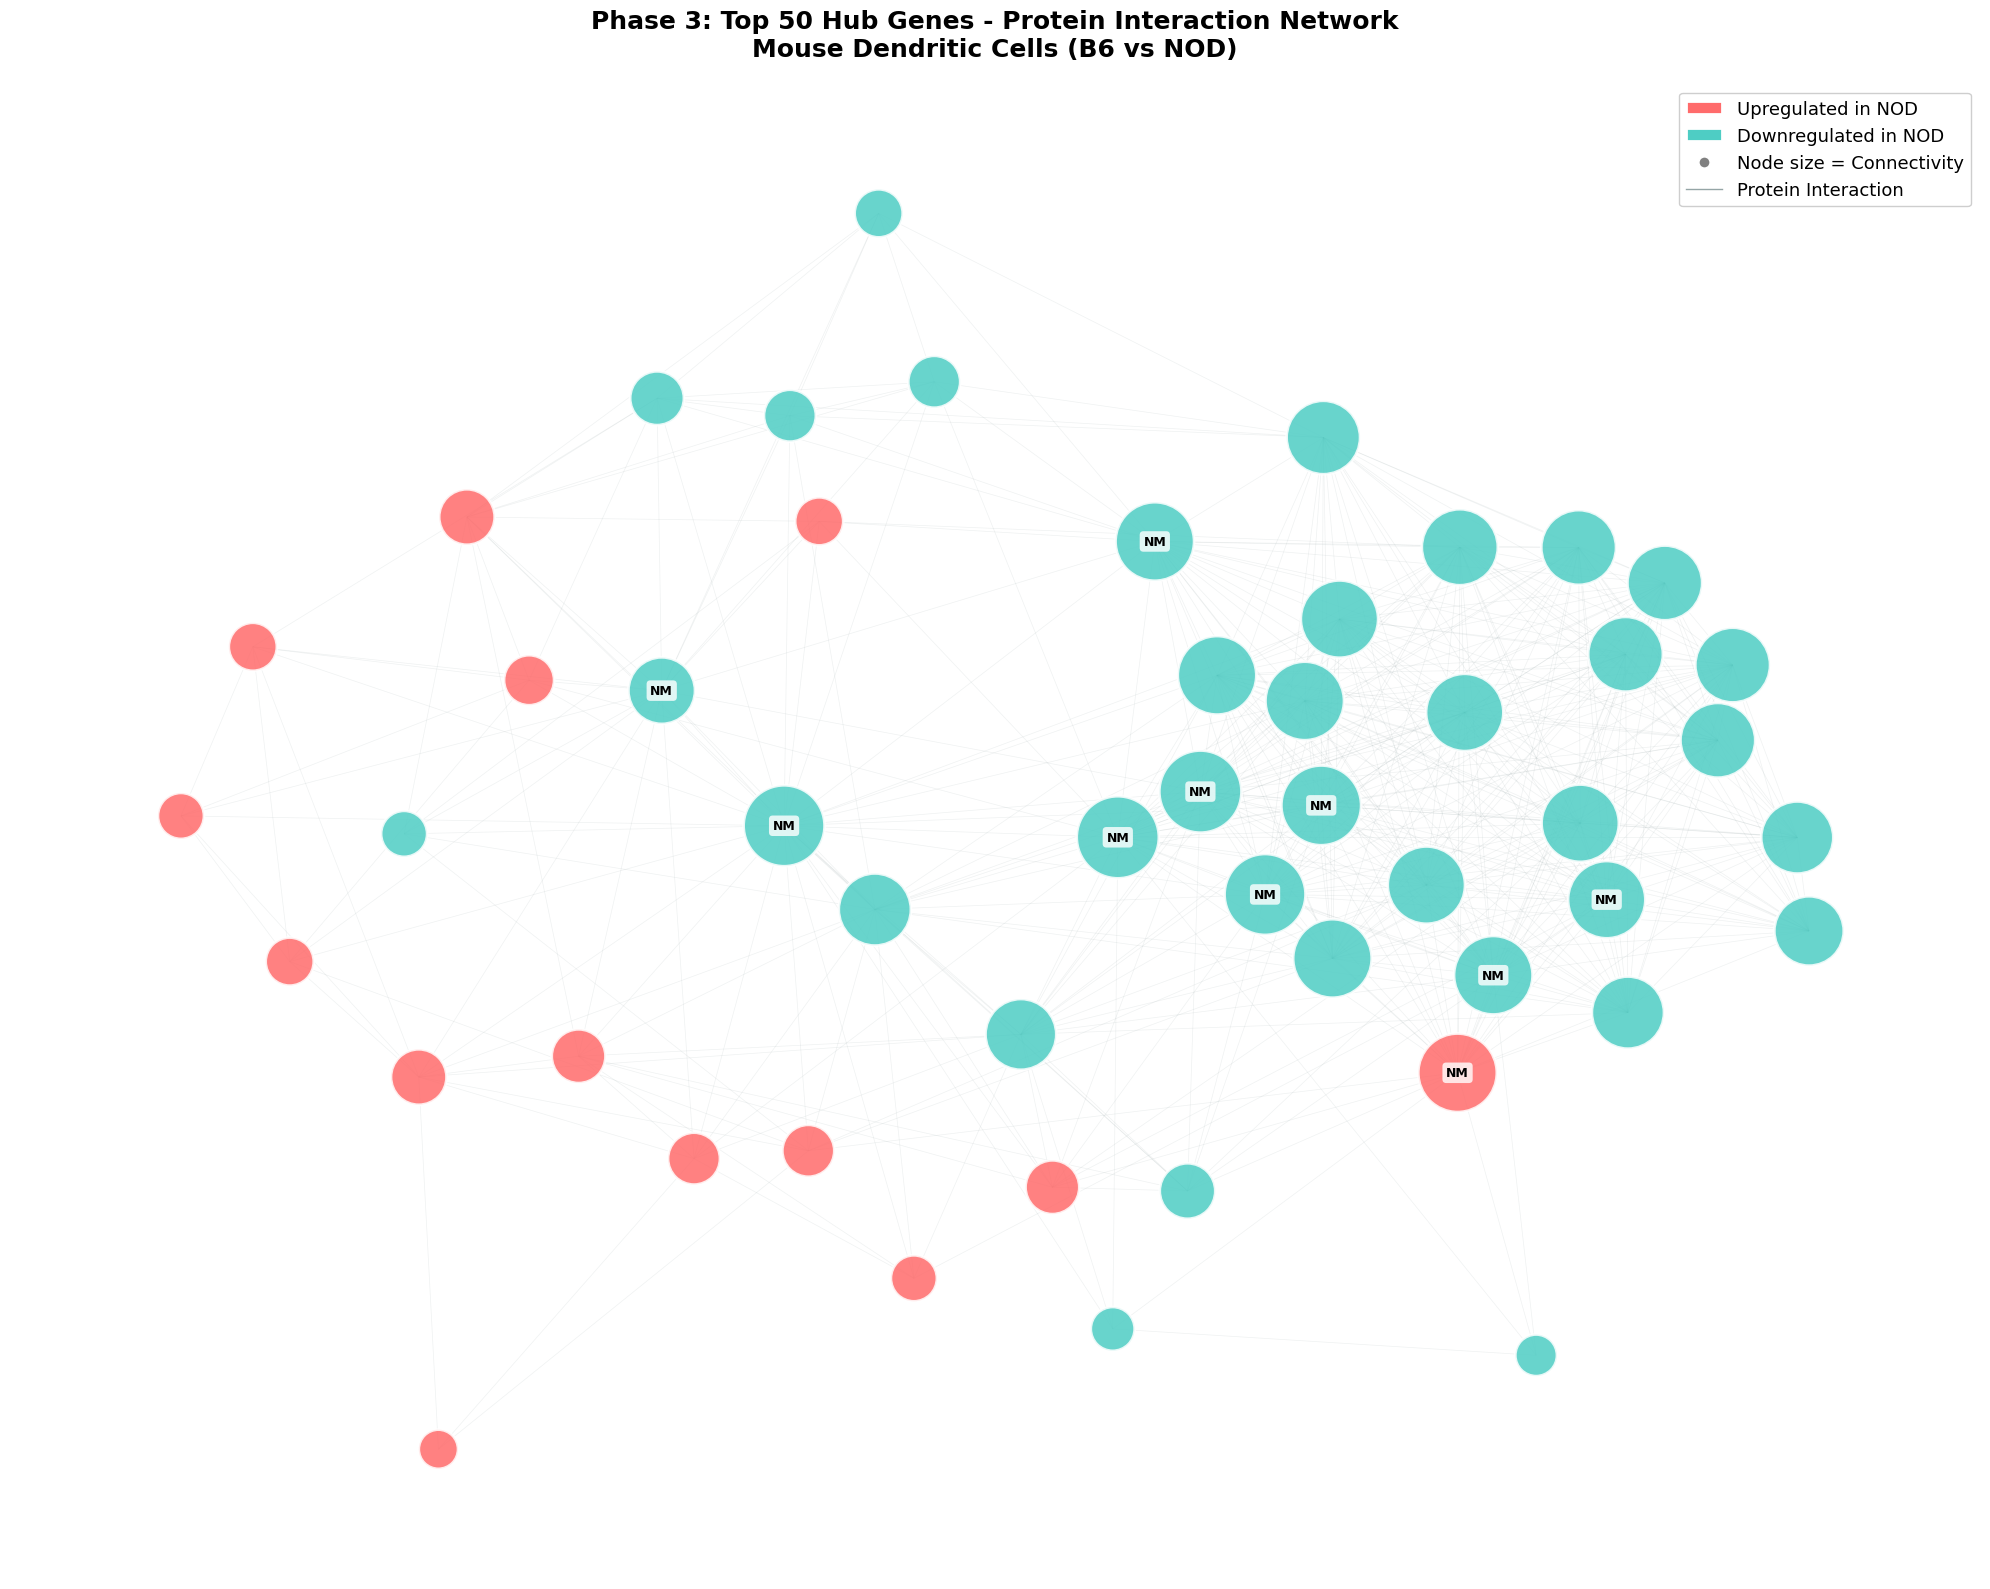

In [4]:
# Visualize the network - IMPROVED VERSION
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

print('\nGenerating improved network visualization...')

# Filter to top 50 most connected nodes for clearer visualization
top_50_nodes = [node for node, _ in sorted_degrees[:50]]
G_viz = G.subgraph(top_50_nodes).copy()

print(f'   Visualizing top 50 hub genes: {len(G_viz.nodes())} nodes, {len(G_viz.edges())} edges')

# Create figure
fig, ax = plt.subplots(figsize=(20, 16))

# Use Kamada-Kawai layout for better spacing (force-directed)
print('   Computing optimal layout...')
pos = nx.kamada_kawai_layout(G_viz)

# Prepare node colors and sizes
node_colors = []
node_sizes = []
for node in G_viz.nodes():
    logFC = G_viz.nodes[node]['logFC']
    degree = G_viz.degree(node)
    
    # Color based on regulation direction
    if logFC > 0:
        node_colors.append('#FF6B6B')  # Lighter red for upregulated
    else:
        node_colors.append('#4ECDC4')  # Teal for downregulated
    
    # Size based on degree (scaled appropriately for 50 nodes)
    node_sizes.append(500 + (degree * 100))

# Draw edges first (thinner, more transparent)
nx.draw_networkx_edges(G_viz, pos, alpha=0.15, width=0.5, edge_color='#95a5a6')

# Draw nodes with edge borders for clarity
nx.draw_networkx_nodes(G_viz, pos, 
                       node_color=node_colors, 
                       node_size=node_sizes, 
                       alpha=0.85,
                       edgecolors='white',
                       linewidths=2)

# Add labels for top 10 key regulators only
top10_nodes = [node for node in top_50_nodes[:10] if node in G_viz.nodes()]
labels = {node: G_viz.nodes[node]['gene_id'].split('_')[0][:15] for node in top10_nodes}  # Shorten labels
nx.draw_networkx_labels(G_viz, pos, labels, 
                       font_size=9, 
                       font_weight='bold',
                       font_color='black',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))

# Add legend
legend_elements = [
    Patch(facecolor='#FF6B6B', edgecolor='white', linewidth=2, label='Upregulated in NOD'),
    Patch(facecolor='#4ECDC4', edgecolor='white', linewidth=2, label='Downregulated in NOD'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=8, label='Node size = Connectivity'),
    plt.Line2D([0], [0], color='#95a5a6', linewidth=1, label='Protein Interaction')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=13, framealpha=0.95)

ax.set_title('Phase 3: Top 50 Hub Genes - Protein Interaction Network\nMouse Dendritic Cells (B6 vs NOD)', 
          fontsize=18, fontweight='bold', pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

## Phase 3 Summary

**Network:** 1,302 nodes, 7,138 edges (STRING PPI, score>400) | Avg degree: 10.96

**Top Hub Genes (Degree Centrality):**

| Rank | Gene ID | Degree | logFC | Direction | FDR |
|------|---------|--------|-------|-----------|-----|
| 1 | NM_008084_6_-_1 | 147 | -1.12 | DOWN | 4.68e-17 |
| 2 | NM_031168_5_+_1 | 119 | -2.18 | DOWN | 7.12e-03 |
| 3 | NM_011664_11_+_1 | 112 | -1.83 | DOWN | 2.88e-15 |
| 4-9 | ... | 73-65 | ... | DOWN | ... |
| 10 | NM_013634_11_-_1 | 64 | 0.92 | UP | 1.11e-02 |

**Key Finding:** 9/10 hub genes downregulated in NOD → coordinated network disruption

**Random Walk:** Identified 14 non-DEG genes proximal to DEGs (Entrez 21849: degree=369, top hit)

**Interpretation:** NOD dendritic cells show systematic hub suppression, indicating network-level immune dysregulation rather than isolated gene defects. Prioritize top 3 hubs (147, 119, 112 connections) for validation.